# Video Preprocessing

## Description

**This notebook shows the flow of the preprocessing pipeline.**

For a single video, then for a set of 6 videos:
- VideoAnalyzer is used to detect motion and pose
    - The RawPoseLandmarks will be loaded and preprocessed in Preprocessor
    - The start_frame and end_frame from the motion analysis will be passed to Preprocessor
- Preprocessor is used to preprocess the video and landmarks
    - The intermediate results are saved to the `Debug` folder for inspection
    - The final preprocessed video and landmarks are saved to the `Videos` and `Landmarks` folders
    - The results are displayed in a few different ways for comparison

The raw videos are loaded from `/data/interim/RawCleanVideos/`
If you don't already have the video files  you can download them from Google Drive.\
(Or you can scrape them directly from the websites using `video_scraping.ipynb`, and apply initial cleaning with `Initial_Cleaning.ipynb`)


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import cv2
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import json

In [3]:
from video_analyzer import VideoAnalyzer
from preprocessor import Preprocessor

2025-04-21 05:56:50.305222: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745182610.484226    1690 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745182610.529828    1690 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-21 05:56:51.010433: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
timestamp = "04142025"
motion_version = "versionB"
pose_version = "versionB"
path_to_root = "/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/"

In [5]:
metadata = pd.read_csv(os.path.join(
    path_to_root,
    "data",
    "raw",
    "combined",
    "target_dataset_video_metadata.csv"
    ))

In [82]:
i = 1
metadata_row = metadata.iloc[i].copy()
metadata_row

filename         ajudar_sb_2.mp4
label                     ajudar
data_source                   sb
sign_id                        1
signer_number                  1
frame_count                   79
fps                     29.97003
duration_sec            2.635967
width                       1280
height                       720
needs_flip                 False
Name: 1, dtype: object

## Initialize VideoAnalyzer

The VideoAnalyzer has default parameters, but individual parameters can be overridden by passing a params_dict to the constructor.

In [83]:
params = {}
params["motion_start_threshold"] = 0.2
# params["verbose"] =False
params["reuse_results"] = True

You can also override the default parameters by having a column in the metadata_row with the same name as the parameter you want to override.

In [8]:
metadata_row.loc['motion_end_threshold'] = 0.3

The priority order is:
1. params_dict
2. metadata_row
3. default parameters

When you call the constructor, it will tell you which parameters are used and from where.

In [9]:
analyzer = VideoAnalyzer(
    metadata_row,
    timestamp,
    path_to_root,
    params,
    verbose=False,
    motion_detection_version=motion_version,
    pose_detection_version=pose_version
)

## Motion Detection

`.motion_detect()` will:
- apply all the motion detection methods specified in the code
- save the raw results in /data/interim/RawMotionMeasurements/version{version}/{filename}_{detection_method}.npy
- (or load the already detected raw results to save reprocessing time if reuse_results is True)
- normalize the raw results to a 0-1 scale and combine them as a weighted average
- apply a moving average to the combined results to smooth the data
- return a dictionary with the derived results

In [10]:
motion_data = analyzer.motion_detect()

window_duration: 0.2 seconds, at 29.97002997002997 fps = 5 frame window_size


`.motion_analyze()` will:
- analyze the motion data to find the start and end frames of meaningful motion
- it requires the motion_data to be loaded/created, and some parameters that are used for the method to decide the start and end frames
- it will return a dictionary with the derived start and end frames, and some other related information

In [11]:
motion_result = analyzer.motion_analyze()

## Pose Estimation

`.pose_detect()` will:
- apply the MediaPipe Holistic model (with some specified parameters) to the video to detect Face, Pose, and Hand Landmarks
- save the raw results in /data/interim/RawPoseLandmarks/version{version}/{filename}.npy
- (or load the already detected raw results to save reprocessing time if reuse_results is True)
- return a dictionary with the derived results


In [12]:
pose_data = analyzer.pose_detect()

Loaded pose estimation results from versionB


`.pose_analyze()` will:
- analyze the loaded/created pose data using various methods from `media_pipe_holistic.py`
- currently this includes:
    - horizontal and vertical positions of various key landmarks
    - various measurements between landmarks
- it will return a dictionary with the results


In [13]:
pose_result = analyzer.pose_analyze()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1745182617.959261   31371 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745182617.996060   31371 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745182617.999164   31371 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745182618.000425   31370 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745182618.001513   31372 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745182618.011638   31

## Save Analysis Info

`.save_analysis_info()` will:
- save all of the analysis info and other metadata to a json file in /data/interim/AnalysisInfo/version{version}/{filename}.json
- it will return a dictionary with the analysis info
- currently this includes:
    - the metadata about the video that was used
    - the parameters used in the detection and analysis
    - the results from the motion detection result analysis
    - the results from the pose detection result analysis


In [14]:
analysis_info = analyzer.save_analysis_info()

In [15]:
analysis_info

{'metadata': {'filename': 'ajudar_sb_2.mp4',
  'fps': 29,
  'width': 1280,
  'height': 720,
  'duration_sec': 2.6359666666666666,
  'frame_count': 79,
  'data_source': 'sb',
  'label': 'ajudar',
  'motion_detection_version': 'versionB',
  'pose_detection_version': 'versionB',
  'timestamp': '04142025'},
 'params': {'motion_avg_weights': {'basic': 0.3, 'bg_sub': 0.7},
  'moving_avg_window_duration': 0.2,
  'motion_threshold_method': 'simple',
  'motion_start_threshold': 0.2,
  'motion_end_threshold': 0.3,
  'pose_static_image_mode': False,
  'pose_model_complexity': 1,
  'pose_smooth_landmarks': True,
  'pose_min_detection_confidence': 0.5,
  'pose_min_tracking_confidence': 0.5,
  'pose_face_ref': 'mean_point',
  'reuse_results': True},
 'motion_analysis': {'start_frame': 8,
  'end_frame': 66,
  'start_time': 0.26693333333333336,
  'end_time': 2.2022,
  'duration_frames': 58,
  'duration_sec': 1.9352666666666667},
 'pose_analysis': {'frames_with_landmarks': 79,
  'horizontal_offsets': {

## Apply Preprocessing

Set the parameters for the preprocessor based on the analysis info

In [84]:
preprocessor_params = {
    "face_width_aim": 0.155,
    "shoulders_width_aim": 0.35,
    "face_midpoint_to_shoulders_height_aim": 0.275,
    "shoulders_y_aim": 0.52,
    "use_statistic": "mean",
    "use_stationary_frames": True,
    "skip_stationary_frames": False,
    "start_frame": analysis_info['motion_analysis']['start_frame'],
    "end_frame": analysis_info['motion_analysis']['end_frame'],
}
preprocessor_params

{'face_width_aim': 0.155,
 'shoulders_width_aim': 0.35,
 'face_midpoint_to_shoulders_height_aim': 0.275,
 'shoulders_y_aim': 0.52,
 'use_statistic': 'mean',
 'use_stationary_frames': True,
 'skip_stationary_frames': False,
 'start_frame': 7,
 'end_frame': 38}

Initialize the preprocessor
- we'll use `verbose=True` to print out the details of the preprocessing
- and `save_intermediate=True` to save the intermediate results of each preprocessing step to look at later

In [35]:
preprocessor = Preprocessor(
    metadata_row,
    preprocessor_params,
    path_to_root,
    preprocess_version='v3',
    verbose=True,
    save_intermediate=True,
)

Initialized Preprocessor for ajudar_sb_2.mp4
Naming this preprocessing version: v3


### Video Preprocessing

In [34]:
preprocessor.preprocess_video()

Preprocessing video: /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/raw/combined/videos/ajudar_sb_2.mp4
>> Saved original video to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/Debug/videos/ajudar_sb_2_original.mp4
Loaded 79 frames from video
Trimmed video from 79 frames to 59 frames
Frame range: 8 to 66
>> Saved intermediate trimmed video to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/Debug/videos/ajudar_sb_2_trimmed.mp4

Scaled frames with factors: x=1.7960656473688834, y=1.2652704014947866
Using edge colors to fill any empty space from scaling
>> Saved intermediate scaled video to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/Debug/videos/ajudar_sb_2_scaled.mp4

Aligned frames with offsets: x=-0.003, y=-0.014
>> Saved intermediate aligned video to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/Debug/videos/ajudar_sb_2_aligned.mp4

>> Saved int

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


Successfully saved video using XVID codec
>> Saved video metadata to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/preprocessed/videos/v3/individual_metadata/ajudar_sb_2.json
>> Saved preprocessed video to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/preprocessed/videos/v3/ajudar_sb_2.mp4 using XVID codec
>> Updated preprocessing metadata CSV at /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/preprocessed/preprocessed_metadata_v3.csv


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


>> Saved debug video to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/Debug/videos/ajudar_sb_2_final.mp4 using XVID codec


'/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/preprocessed/videos/v3/ajudar_sb_2.mp4'

### Landmarks Preprocessing

In [64]:
preprocessor.preprocess_landmarks()

Preprocessing landmarks: /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawPoseLandmarks/versionB/ajudar_sb_2.npy
>> Saved original landmarks to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/Debug/landmarks/ajudar_sb_2_original.npy
Loaded landmarks with shape: (79,)
Used 20 stationary frames for reference points calculation. 0 frames had None landmarks.
Scaled landmarks with factors: x=1.7960656473688834, y=1.2652704014947866
>> Saved intermediate scaled landmarks to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/Debug/landmarks/ajudar_sb_2_scaled.npy

Used 20 stationary frames for reference points calculation. 0 frames had None landmarks.
Aligned landmarks with offsets: horizontal=-0.404, vertical=-0.156
>> Saved intermediate aligned landmarks to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/Debug/landmarks/ajudar_sb_2_aligned.npy

Used 20 stationary frames for referen

'/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/preprocessed/landmarks/v3/ajudar_sb_2.npy'

# See steps

This section shows the intermediate steps of the landmarks preprocessing for that single video.

In [49]:
import vizualisation as viz

In [50]:
steps = [
    'original',
    'scaled',
    'aligned',
    'trimmed',
    'final',
]

In [51]:
original_video_path = os.path.join(
    path_to_root,
    "data",
    "raw",
    "combined",
    "videos", metadata_row["filename"])
original_video_path

'/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/raw/combined/videos/ajudar_sb_2.mp4'

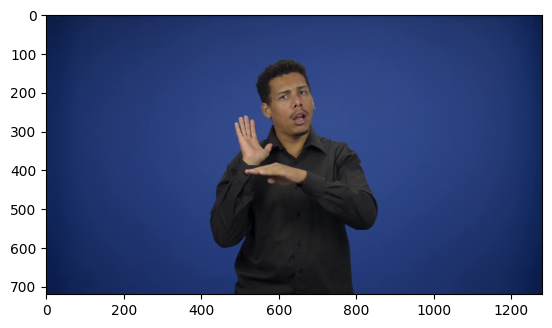

In [52]:
frame = viz.get_frame(20, original_video_path)
plt.imshow(frame)

### Landmarks Preprocessing

In [80]:
frame_index = 20

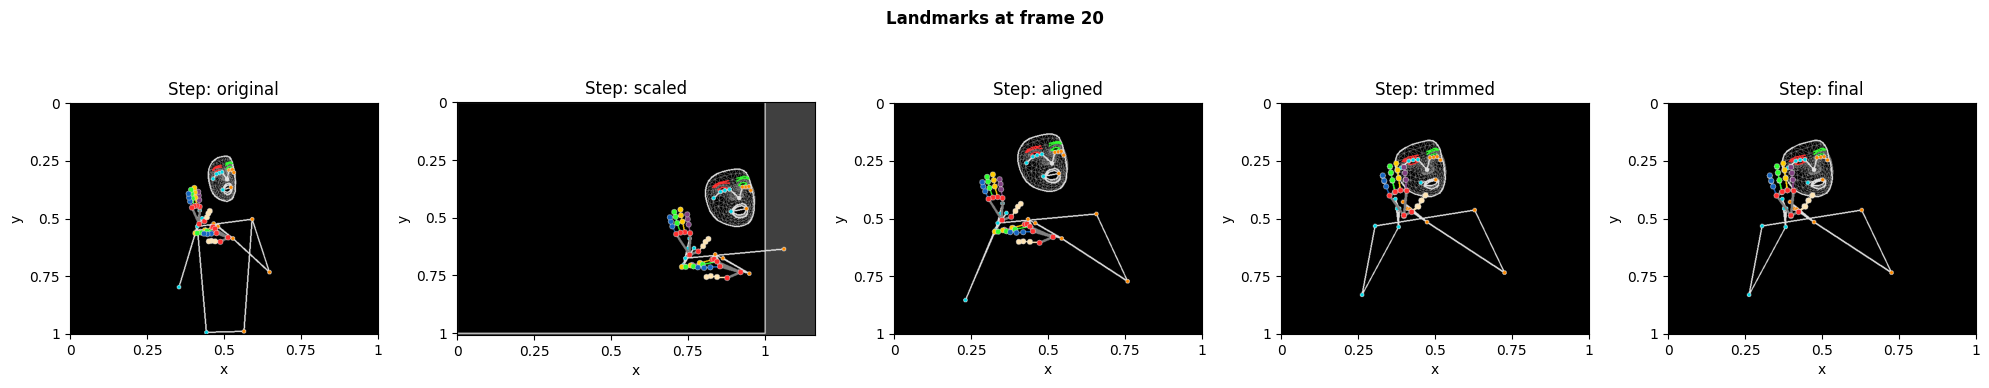

In [102]:
# Get all frames first
frames = []
for step in steps:
    landmarks_path = os.path.join(
        path_to_root,
        "data", 
        "interim",
        "Debug",
        "landmarks", metadata_row["filename"].split(".")[0] + f"_{step}.npy")
    landmarks = np.load(landmarks_path, allow_pickle=True)
    drawn_frame = viz.draw_landmarks_on_frame(np.zeros((480,640,3), dtype=np.uint8), landmarks[frame_index])
    frames.append(drawn_frame)

# Calculate width ratios based on frame widths
widths = [frame.shape[1] for frame in frames]
width_ratios = [w/min(widths) for w in widths]

# Create plot
fig = plt.figure(figsize=(20, 4))
gs = fig.add_gridspec(1, len(steps), width_ratios=width_ratios)
fig.suptitle("Landmarks at frame 20", fontweight="bold")

for i, (step, spec, frame) in enumerate(zip(steps, gs, frames)):
    ax = fig.add_subplot(spec)
    ax.imshow(frame[:,:,::-1])
    ax.set_title(f"Step: {step}")

    ax.set_xticks([0, 160, 320, 480, 640])
    ax.set_xticklabels([0, 0.25, 0.5, 0.75, 1])
    ax.set_yticks([0, 120, 240, 360, 480]) 
    ax.set_yticklabels([0, 0.25, 0.5, 0.75, 1])
    ax.set_xlabel("x")
    ax.set_ylabel("y")
plt.tight_layout()
plt.show()

### Video Preprocessing

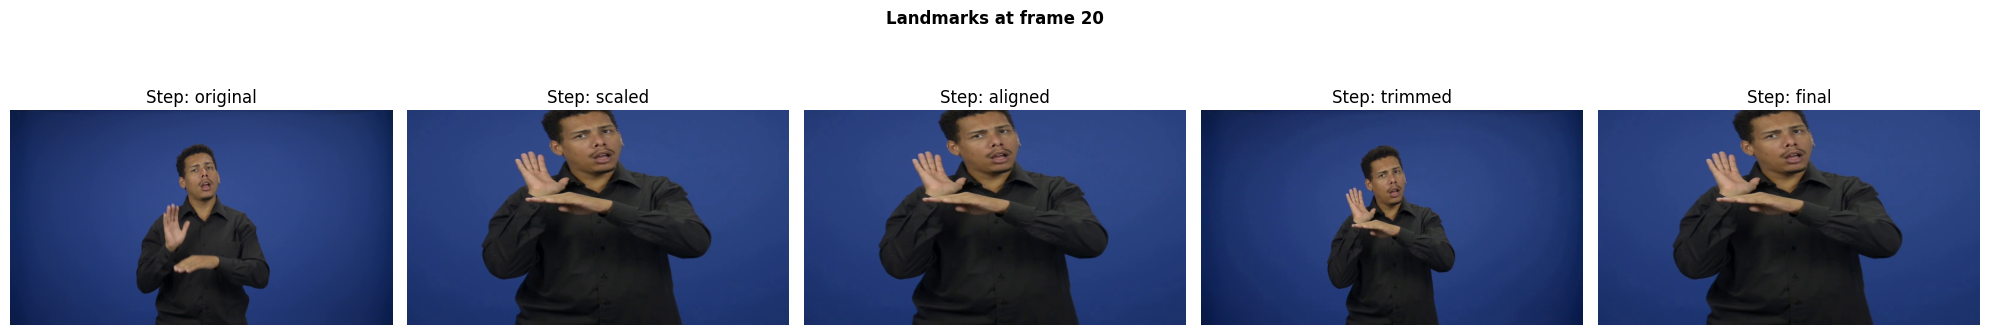

In [75]:
# subplots
fig, axs = plt.subplots(1, len(steps), figsize=(20, 4))
fig.suptitle("Landmarks at frame 20", fontweight="bold")


for step, ax in zip(steps, axs.flatten()):
    video_path = os.path.join(
        path_to_root,
        "data",
        "interim",
        "Debug",
        "videos", metadata_row["filename"].split(".")[0] + f"_{step}.mp4")
    frame = viz.get_frame(frame_index, video_path)
    ax.imshow(frame)
    ax.set_title(f"Step: {step}")
    ax.axis('off')
plt.tight_layout()
plt.show()

## Multiple Videos

This section uses a sample of 6 videos from the dataset to show:
- the video analysis steps applied to multiple videos
- the preprocessing steps applied to multiple videos
- the orignal and preprocessed videos of the 6 samples for comparison


In [76]:
sample_metadata = metadata[metadata.label == "ajudar"].copy()
sample_metadata

,filename,label,data_source,sign_id,signer_number,frame_count,fps,duration_sec,width,height,needs_flip
0,ajudar_ne_1.mp4,ajudar,ne,2,1,44,12.00000,3.666667,240,176,False
1,ajudar_sb_2.mp4,ajudar,sb,1,1,79,29.97003,2.635967,1280,720,False
2,ajudar_uf_3.mp4,ajudar,uf,0,1,115,29.97003,3.837167,480,270,False
3,ajudar_vl_4.mp4,ajudar,vl,0,1,141,29.97003,4.704700,1920,1080,False
4,ajudar_vl_5.mp4,ajudar,vl,0,2,289,29.97003,9.642967,1920,1080,False
5,ajudar_vl_6.mp4,ajudar,vl,0,3,310,60.00000,5.166667,1920,1080,False


### Video Analyze

In [77]:
for i, metadata_row in sample_metadata.iterrows():
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
    analyzer = VideoAnalyzer(
        metadata_row,
        timestamp,
        path_to_root,
        verbose=False,
        motion_detection_version=motion_version,
        pose_detection_version=pose_version
    )
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'

    motion_data = analyzer.motion_detect()
    motion_result = analyzer.motion_analyze()

    pose_data = analyzer.pose_detect()
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    pose_result = analyzer.pose_analyze()
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'

    analyzer.save_analysis_info()

window_duration: 0.2 seconds, at 12.0 fps = 2 frame window_size
Loaded pose estimation results from versionB


W0000 00:00:1745242093.046240   84917 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745242093.101157   84914 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745242093.105494   84914 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745242093.106787   84913 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745242093.115007   84915 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745242093.117012   84914 inference_feedback_manager.cc:114] Feedback manager 

window_duration: 0.2 seconds, at 29.97002997002997 fps = 5 frame window_size
Loaded pose estimation results from versionB
window_duration: 0.2 seconds, at 29.97002997002997 fps = 5 frame window_size
Loaded pose estimation results from versionB


W0000 00:00:1745242093.256650   84923 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745242093.258524   84922 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745242093.259624   84926 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745242093.259769   84923 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745242093.274535   84923 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745242093.279016   84922 inference_feedback_manager.cc:114] Feedback manager 

window_duration: 0.2 seconds, at 29.97002997002997 fps = 5 frame window_size
Loaded pose estimation results from versionB


W0000 00:00:1745242093.638978   84939 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745242093.702663   84939 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745242093.705255   84937 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745242093.705374   84943 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745242093.705866   84938 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745242093.718853   84939 inference_feedback_manager.cc:114] Feedback manager 

window_duration: 0.2 seconds, at 29.97002997002997 fps = 5 frame window_size
Loaded pose estimation results from versionB
window_duration: 0.2 seconds, at 60.0 fps = 12 frame window_size


W0000 00:00:1745242093.872261   84947 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745242093.898050   84947 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745242093.900316   84945 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745242093.900487   84951 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745242093.901047   84947 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745242093.912412   84947 inference_feedback_manager.cc:114] Feedback manager 

Loaded pose estimation results from versionB


W0000 00:00:1745242094.074449   84955 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745242094.115553   84956 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745242094.118277   84957 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745242094.118697   84960 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745242094.120725   84958 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745242094.132527   84960 inference_feedback_manager.cc:114] Feedback manager 

### Preprocess

In [78]:
sample_metadata[4:]

,filename,label,data_source,sign_id,signer_number,frame_count,fps,duration_sec,width,height,needs_flip
4,ajudar_vl_5.mp4,ajudar,vl,0,2,289,29.97003,9.642967,1920,1080,False
5,ajudar_vl_6.mp4,ajudar,vl,0,3,310,60.00000,5.166667,1920,1080,False


In [104]:
for i, metadata_row in sample_metadata.iterrows():
    
    analysis_info_path = os.path.join(
        path_to_root, 
        "data", 
        "interim", 
        "Analysis", 
        f"{timestamp}_motion{motion_version}_pose{pose_version}", 
        metadata_row["filename"].split(".")[0] + "_analysis_info.json"
    )
    
    with open(analysis_info_path) as f:
        analysis_info = json.load(f)
    
    preprocessor_params = {
    "face_width_aim": 0.155,
    "shoulders_width_aim": 0.35,
    "face_midpoint_to_shoulders_height_aim": 0.275,
    "shoulders_y_aim": 0.52,
    "use_statistic": "mean",
    "use_stationary_frames": True,
    "skip_stationary_frames": False,
    "start_frame": analysis_info['motion_analysis']['start_frame'],
    "end_frame": analysis_info['motion_analysis']['end_frame'],
    }

    preprocessor = Preprocessor(
        metadata_row,
        preprocessor_params,
        path_to_root,
        preprocess_version='v3',
        verbose=True,
        save_intermediate=True,
    )

    # preprocessor.preprocess_video()
    
    # Clear memory before processing landmarks
    import gc
    gc.collect()
    
    # Process landmarks
    preprocessor.preprocess_landmarks()
    
    # Clear memory before next iteration
    del preprocessor
    del analysis_info
    gc.collect()

Initialized Preprocessor for ajudar_ne_1.mp4
Naming this preprocessing version: v3
Preprocessing landmarks: /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawPoseLandmarks/versionB/ajudar_ne_1.npy
>> Saved original landmarks to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/Debug/landmarks/ajudar_ne_1_original.npy
Loaded landmarks with shape: (44,)
Used 12 stationary frames for reference points calculation. 0 frames had None landmarks.
Scaled landmarks with factors: x=1.0506675543296873, y=0.9411540938318022
>> Saved intermediate scaled landmarks to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/Debug/landmarks/ajudar_ne_1_scaled.npy

Used 12 stationary frames for reference points calculation. 0 frames had None landmarks.
Aligned landmarks with offsets: horizontal=-0.015, vertical=-0.006
>> Saved intermediate aligned landmarks to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/int

### Vizualisation

In [105]:
import vizualisation as viz

In [106]:
preprocessed_metadata = pd.read_csv(os.path.join(
    path_to_root,
    "data",
    "preprocessed",
    "preprocessed_metadata_v2.csv"))
sample_preprocessed_metadata = preprocessed_metadata[preprocessed_metadata.label == "ajudar"]
sample_preprocessed_metadata

,filename,label,data_source,original_fps,original_width,original_height,original_frame_count,original_duration_sec,original_start_frame,original_end_frame,preprocessed_frame_count,preprocessed_duration_sec,preprocessed_start_frame,preprocessed_end_frame,horizontal_offset,vertical_offset,x_scale_factor,y_scale_factor,preprocess_version
0,ajudar_ne_1.mp4,ajudar,ne,12.00000,240,176,44,3.666667,7,38,72,6,20,51,0.019842,-0.006084,0.784180,0.965865,v2
1,ajudar_sb_2.mp4,ajudar,sb,29.97003,1280,720,79,2.635967,8,71,179,6,57,120,0.003489,-0.018081,1.254403,1.168761,v2
2,ajudar_uf_3.mp4,ajudar,uf,29.97003,480,270,115,3.837167,25,105,179,6,49,129,0.008005,-0.081231,1.233224,1.172439,v2
3,ajudar_vl_4.mp4,ajudar,vl,29.97003,1920,1080,141,4.704700,12,138,179,6,26,152,-0.003169,0.058254,1.220824,1.018915,v2
4,ajudar_vl_5.mp4,ajudar,vl,29.97003,1920,1080,289,9.642967,4,287,179,6,56,234,0.000964,-0.035512,1.011627,0.996811,v2
5,ajudar_vl_6.mp4,ajudar,vl,60.00000,1920,1080,310,5.166667,7,308,360,6,29,330,-0.013912,0.024258,0.968659,1.045554,v2


In [107]:
ref_points = {
'face_horizontal_offset': 0.5,
'face_vertical_offset': 0.245,
'face_width': 0.155,
'face_height': 0.23,
'shoulders_horizontal_offset': 0.5,
'shoulders_vertical_offset': 0.52,
'shoulders_width': 0.35,
 
    "face_width_aim": 0.155,
    "shoulders_width_aim": 0.35,
    "face_midpoint_to_shoulders_height_aim": 0.275,
    "shoulders_y_aim": 0.52,
    "use_statistic": "mean",
    "use_stationary_frames": True,
    "skip_stationary_frames": False,
    "start_frame": analysis_info['motion_analysis']['start_frame'],
    "end_frame": analysis_info['motion_analysis']['end_frame'],
    }


In [50]:
frame_index = 10

### Preprocessed Landmarks 

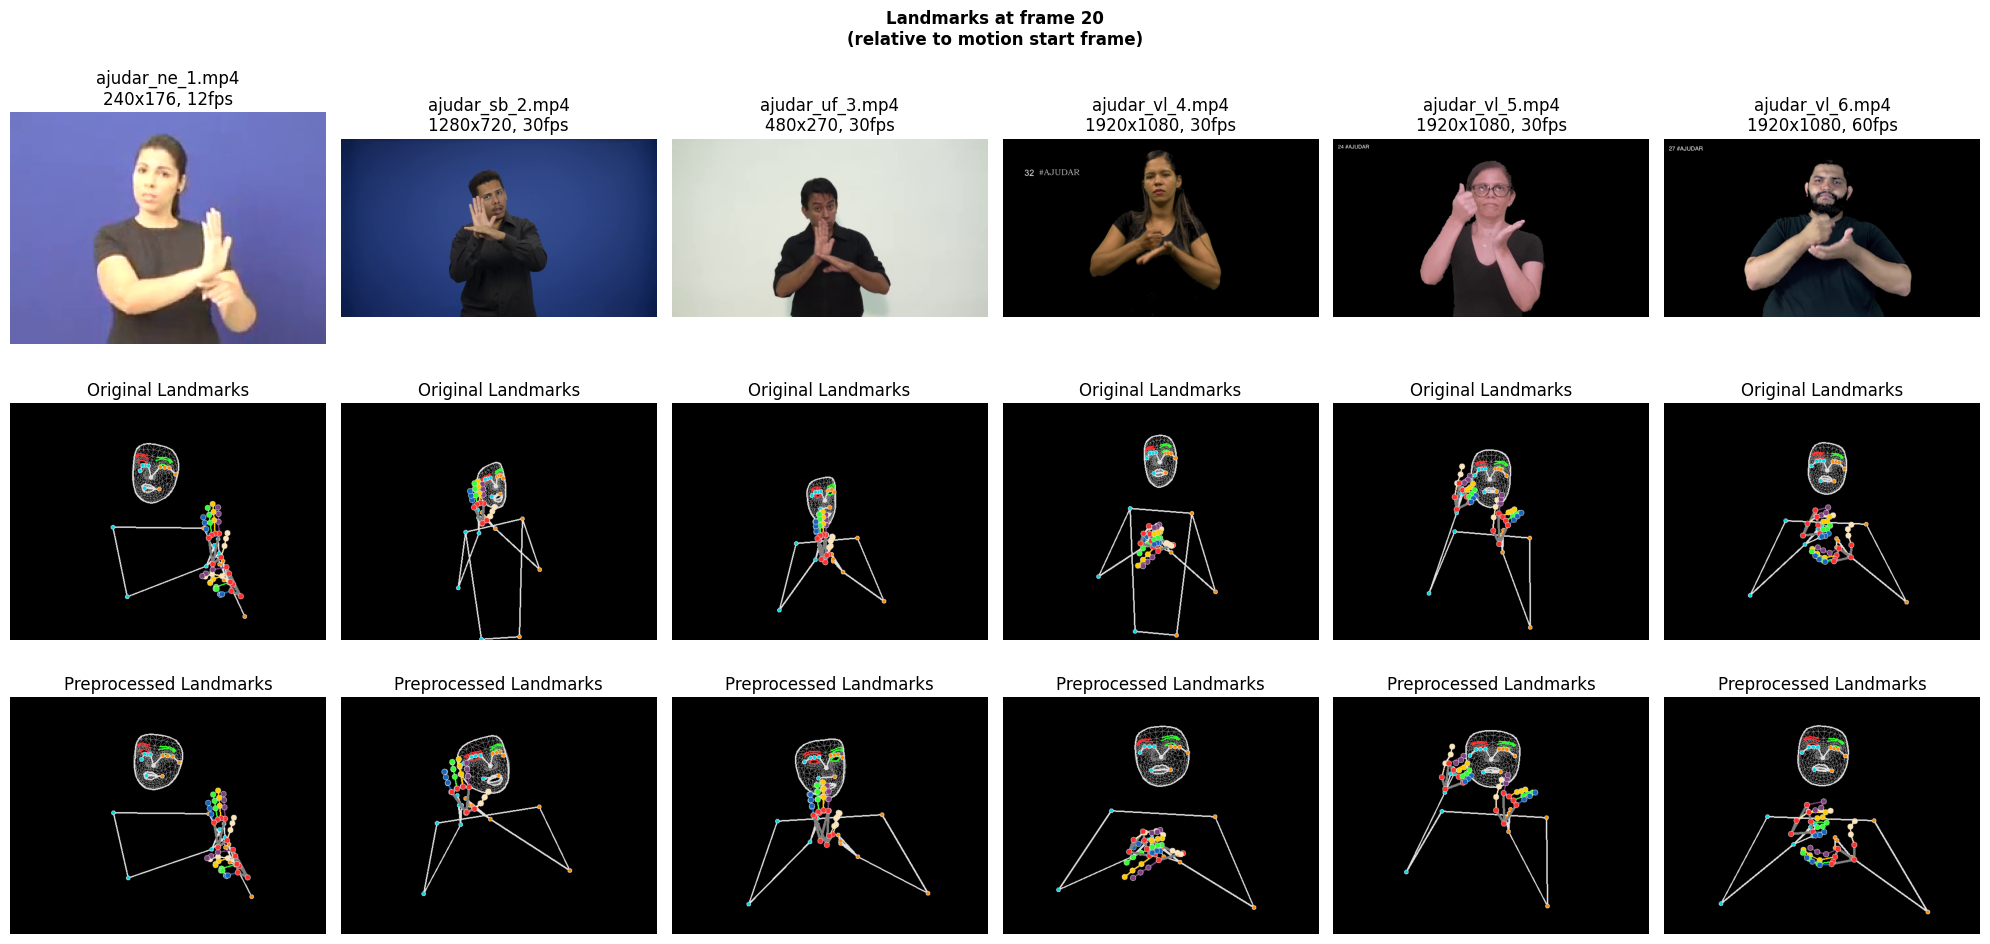

In [110]:
# subplots
fig, axs = plt.subplots(3, len(sample_preprocessed_metadata), figsize=(20, 10))
fig.suptitle(f"Landmarks at frame {frame_index}\n(relative to motion start frame)", fontweight="bold")


for (i, row), ax in zip(sample_preprocessed_metadata.iterrows(), axs.T):
    debug_landmarks_path = os.path.join(
        path_to_root,
        "data",
        "interim",
        "Debug",
        "landmarks", row["filename"].split(".")[0])
    preprocessed_landmarks_path = os.path.join(
        path_to_root,
        "data",
        "preprocessed",
        "landmarks",
        "v3", row["filename"].split(".")[0])
    video_path = os.path.join(
        path_to_root,
        "data",
        "interim",
        "Debug",
        "videos", row["filename"].split(".")[0] + f"_original.mp4")

    original_start_frame = row['original_start_frame']
    preprocessed_start_frame = row['preprocessed_start_frame']
    frame = viz.get_frame(original_start_frame+frame_index, video_path)

    original_landmarks_path = debug_landmarks_path + "_original.npy"
    preprocessed_landmarks_path = preprocessed_landmarks_path + ".npy"

    original_landmarks = np.load(original_landmarks_path, allow_pickle=True)
    final_landmarks = np.load(preprocessed_landmarks_path, allow_pickle=True)

    original_drawn_frame = viz.draw_landmarks_on_frame(np.zeros((480,640,3), dtype=np.uint8), original_landmarks[original_start_frame+frame_index])
    final_drawn_frame = viz.draw_landmarks_on_frame(np.zeros((480,640,3), dtype=np.uint8), final_landmarks[frame_index])

    ax[0].imshow(frame)
    ax[1].imshow(original_drawn_frame[:,:,::-1])
    ax[2].imshow(final_drawn_frame[:,:,::-1])
    ax[0].set_title(f"{row['filename']}\n{row['original_width']}x{row['original_height']}, {int(round(row['original_fps']))}fps")
    ax[1].set_title(f"Original Landmarks")
    ax[2].set_title(f"Preprocessed Landmarks")
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
plt.tight_layout()
plt.show()

### Preprocessed Videos

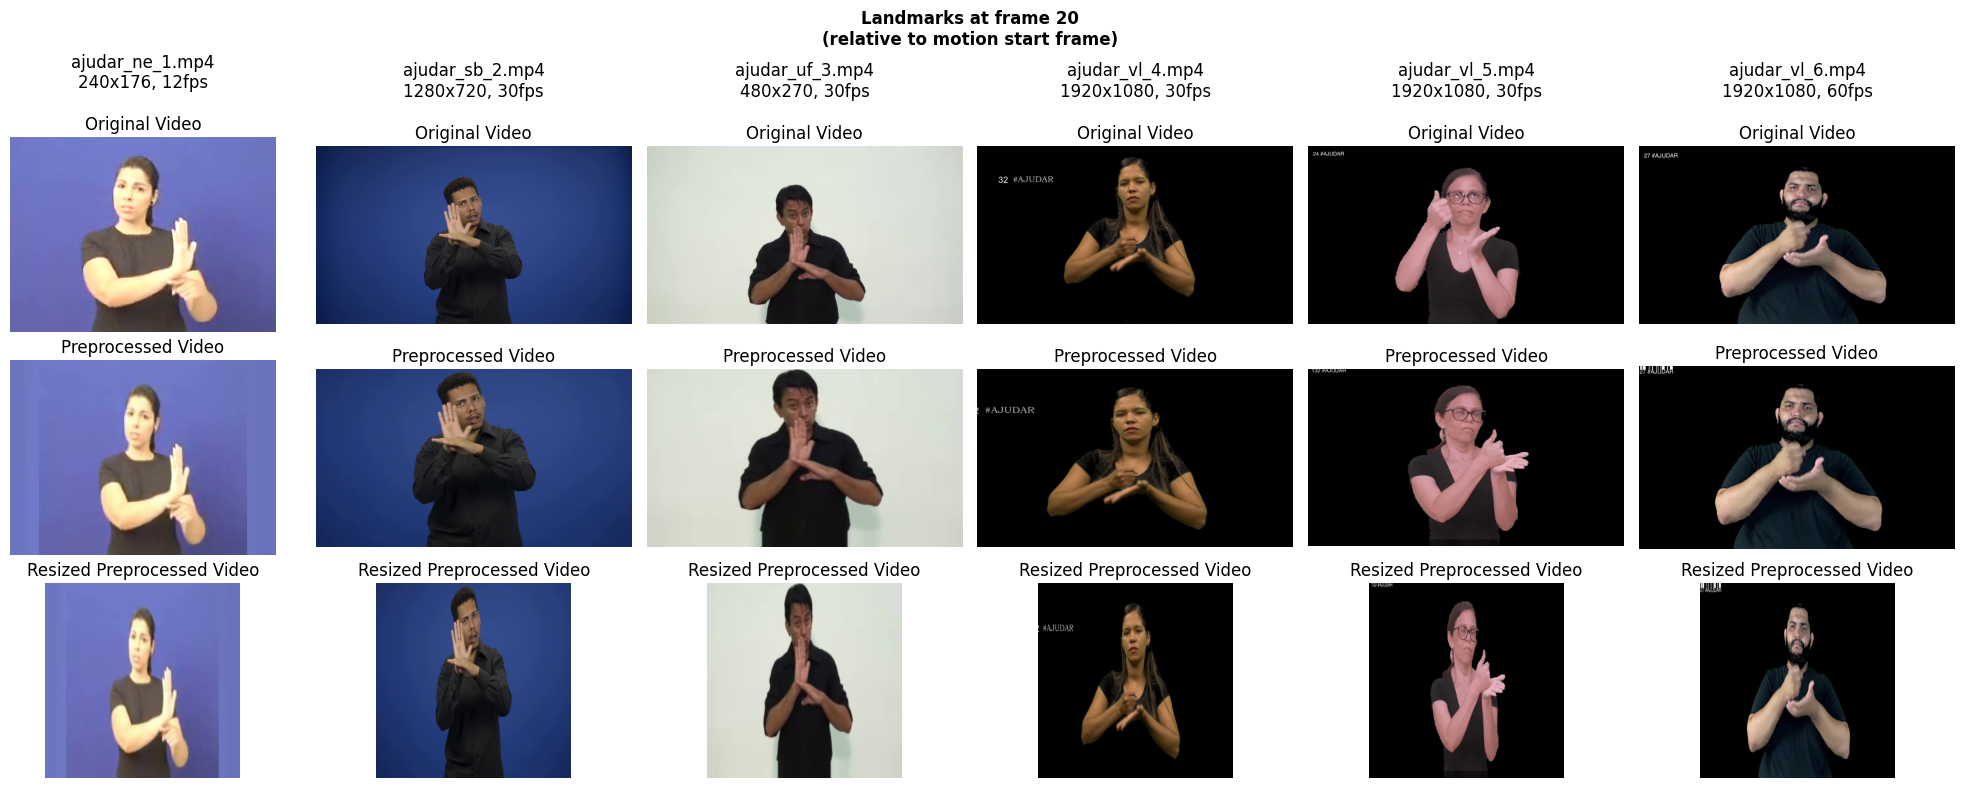

In [111]:
# subplots
fig, axs = plt.subplots(3, len(sample_preprocessed_metadata), figsize=(20, 8))
fig.suptitle(f"Landmarks at frame {frame_index}\n(relative to motion start frame)", fontweight="bold")


for (i, row), ax in zip(sample_preprocessed_metadata.iterrows(), axs.T):

    video_path = os.path.join(
        path_to_root,
        "data",
        "interim",
        "Debug",
        "videos", row["filename"].split(".")[0] + f"_original.mp4")
    processed_video_path = os.path.join(
        path_to_root,
        "data",
        "preprocessed",
        "videos",
        "v2",
        row["filename"])

    original_start_frame = row['original_start_frame']
    preprocessed_start_frame = row['preprocessed_start_frame']

    original_frame = viz.get_frame(frame_index + original_start_frame, video_path)
    processed_frame = viz.get_frame(frame_index + preprocessed_start_frame, processed_video_path)
    target_dims = (640, 640)
    resized_processed_frame = cv2.resize(processed_frame, target_dims)
    # drawn_processed_frame = viz.plot_key_landmarks(
    #     landmark_points=ref_points,
    #     frame=processed_frame,
    #     line_color=(0, 255, 0),
    #     line_width=2,
    #     axis_lines=True,
    # )

    ax[0].imshow(original_frame)
    ax[1].imshow(processed_frame)
    ax[2].imshow(resized_processed_frame)
    ax[0].set_title(f"{row['filename']}\n{row['original_width']}x{row['original_height']}, {int(round(row['original_fps']))}fps\n\nOriginal Video")
    ax[1].set_title(f"Preprocessed Video")
    ax[2].set_title(f"Resized Preprocessed Video")
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
plt.tight_layout()
plt.show()